# Propensity Score Matcher

In this notebook, we show the basic usage of the PropensityScoreMatcher. Unlike the GeneticMatcher and ConstraintSatisfactionMatcher, the PropensityScoreMatcher does not directly optimize a  particular balance score. Instead, the PropensityScoreMatcher uses the given objective as a measure of "correctness" of the propensity score model. The matcher tries a (possibly large) number of potential models and returns the model with the best score according to the given metric. In doing this, we are essentially automating an often manual process of hyperparameter optimization that accompanies propensity score matching.

We show that the hyperparameter search still leaves unoptimized balance by apply a ConstraintSatisfactionMatcher
to the resulting population from the PropensityScoreMatcher. The residual unoptimzed balance highlights a major
limitation of propensity score matching in general.

In [1]:
import logging 
logging.basicConfig(
    format="%(levelname)-4s [%(filename)s:%(lineno)d] %(message)s",
    level='INFO',
)

from pybalance.utils import *
from pybalance.sim import generate_toy_dataset
from pybalance.propensity import PropensityScoreMatcher, plot_propensity_score_match_distributions
from pybalance.visualization import (
    plot_numeric_features, 
    plot_categoric_features, 
    plot_binary_features,
    plot_joint_numeric_distributions,
    plot_per_feature_loss
)

In [2]:
m = generate_toy_dataset(n_pool=10000, n_target=1000, seed=123)
m

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
0,60.807949,173.610298,77.912924,0.0,1,4,pool,0,0,1,1,0
1,45.810836,170.541198,112.416988,0.0,1,4,pool,0,1,0,0,1
2,58.876976,188.138610,108.789013,0.0,0,2,pool,0,0,1,1,2
3,73.398077,162.939196,65.345017,0.0,1,4,pool,0,1,1,1,3
4,56.890587,156.386701,78.140295,0.0,0,3,pool,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
995,39.662026,162.692755,54.607476,0.0,2,4,target,0,0,1,1,10995
996,49.130301,141.583192,103.798145,1.0,0,2,target,1,0,0,0,10996
997,68.035281,168.744482,56.499644,1.0,1,1,target,0,0,0,1,10997
998,62.044564,177.796983,75.983973,1.0,1,1,target,0,0,0,1,10998


## Optimize Beta (Mean Absolute SMD)


Using the given objective function, search max_iter possible different propensity score models and take the model that gives the best match given that objective function.

In [3]:
# Note that using a caliper can result in matched population being 
# smaller than target! If this is undesired, do not use a caliper.
objective = beta = BetaBalance(m)
matcher = PropensityScoreMatcher(
    matching_data=m,
    objective=objective,
    time_limit=300,
    max_iter=100)
matcher.get_params()

{'objective': 'beta',
 'caliper': None,
 'max_iter': 100,
 'time_limit': 300,
 'method': 'greedy'}

In [4]:
matcher.match()

INFO [matcher.py:180] Training model LogisticRegression (iter 1/100, 0.000 min) ...
INFO [matcher.py:136] Best propensity score match found:
INFO [matcher.py:137] 	Model: LogisticRegression
INFO [matcher.py:139] 	* C: 0.023702966007283093
INFO [matcher.py:139] 	* fit_intercept: False
INFO [matcher.py:139] 	* max_iter: 500
INFO [matcher.py:139] 	* penalty: l2
INFO [matcher.py:139] 	* solver: saga
INFO [matcher.py:140] 	Score (beta): 0.0444
INFO [matcher.py:141] 	Solution time: 0.001 min
INFO [matcher.py:180] Training model SGDClassifier (iter 2/100, 0.001 min) ...
INFO [matcher.py:180] Training model SGDClassifier (iter 3/100, 0.002 min) ...
INFO [matcher.py:180] Training model LogisticRegression (iter 4/100, 0.003 min) ...
/opt/miniconda3/envs/pybalance/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
INFO [matcher.py:136] Best propensity score match found:
INFO [matcher.py

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
5781,74.382687,194.082038,118.760023,0.0,2,5,pool,1,0,0,0,5781
6714,66.581290,178.545534,102.566840,0.0,2,2,pool,1,0,0,0,6714
9937,61.860293,159.449219,108.945960,0.0,2,4,pool,1,0,0,1,9937
8223,46.656414,140.392554,65.453208,1.0,2,4,pool,1,0,0,1,8223
962,52.829914,137.725077,93.206007,0.0,1,2,pool,1,1,0,0,962
...,...,...,...,...,...,...,...,...,...,...,...,...
995,39.662026,162.692755,54.607476,0.0,2,4,target,0,0,1,1,10995
996,49.130301,141.583192,103.798145,1.0,0,2,target,1,0,0,0,10996
997,68.035281,168.744482,56.499644,1.0,1,1,target,0,0,0,1,10997
998,62.044564,177.796983,75.983973,1.0,1,1,target,0,0,0,1,10998


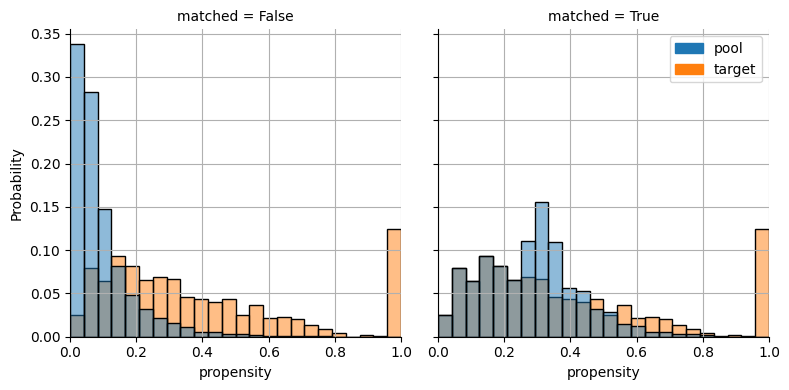

In [5]:
%matplotlib inline
plot_propensity_score_match_distributions(matcher)


INFO [matcher.py:136] Best propensity score match found:
INFO [matcher.py:137] 	Model: LogisticRegression
INFO [matcher.py:139] 	* C: 0.6191810056908827
INFO [matcher.py:139] 	* fit_intercept: False
INFO [matcher.py:139] 	* max_iter: 500
INFO [matcher.py:139] 	* penalty: l1
INFO [matcher.py:139] 	* solver: saga
INFO [matcher.py:140] 	Score (beta): 0.0307
INFO [matcher.py:141] 	Solution time: 0.256 min


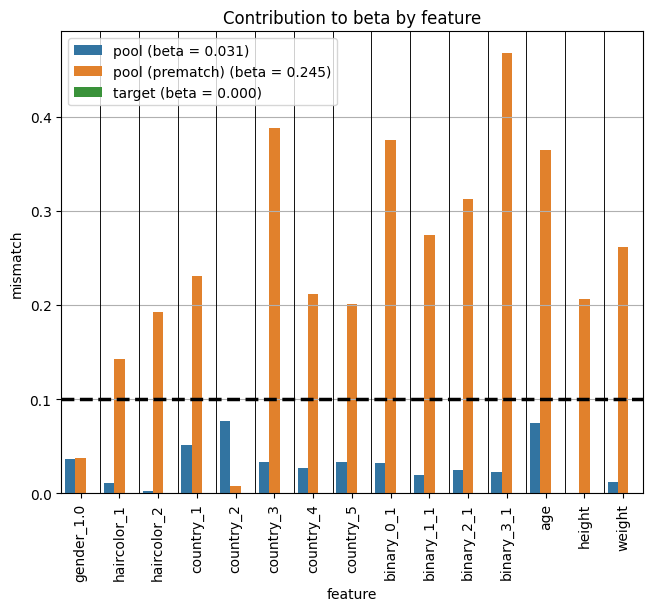

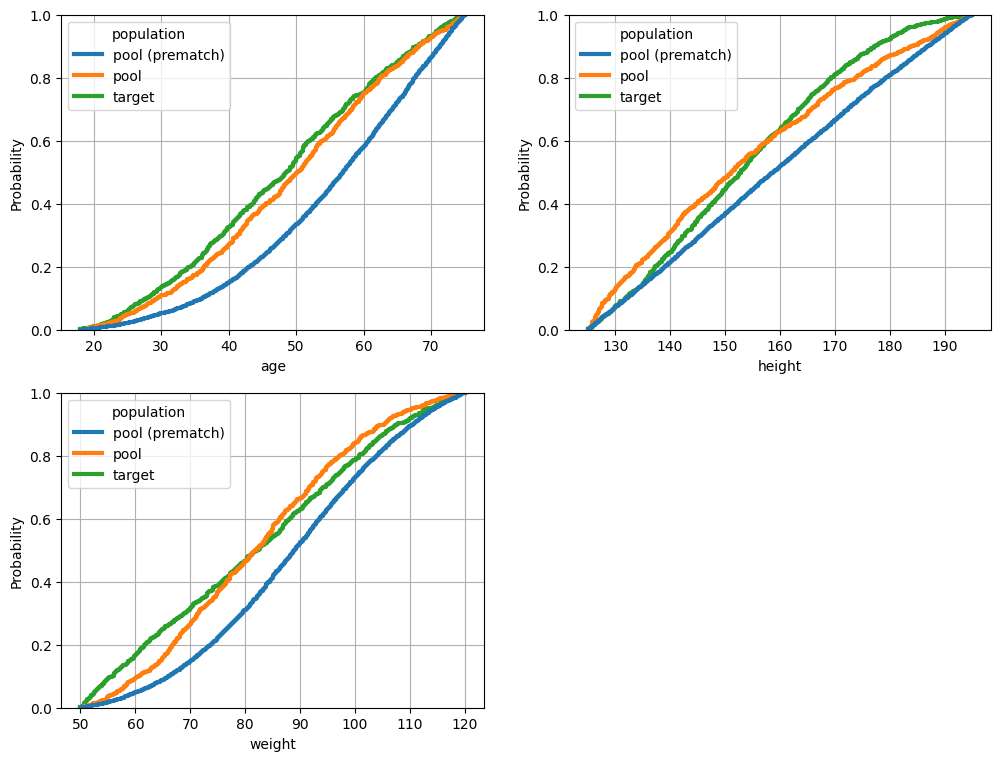

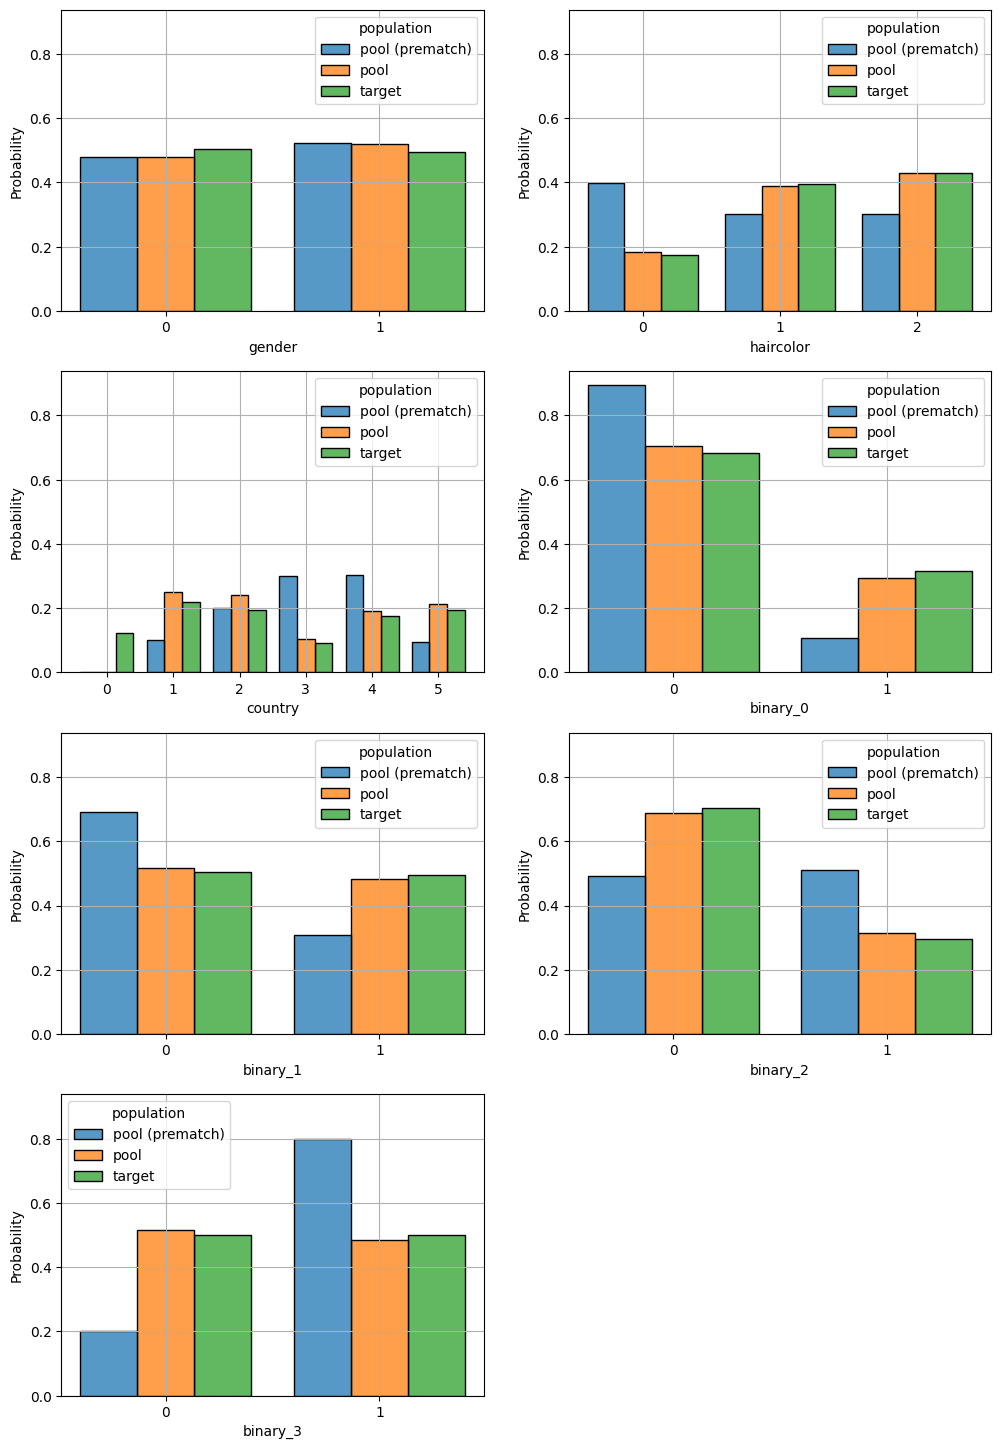

In [6]:
%matplotlib inline
objective = beta = BetaBalance(m)

match = matcher.get_best_match()
m_data = m.copy().get_population('pool')
m_data.loc[:, 'population'] = m_data['population'] + ' (prematch)'
match.append(m_data)
fig = plot_per_feature_loss(match, beta, 'target', debin=False)
fig = plot_numeric_features(match, hue_order=['pool (prematch)', 'pool', 'target', ])
fig = plot_categoric_features(match,  hue_order=['pool (prematch)', 'pool', 'target'])

## Improve upon PropensityScoreMatcher solution with ConstraintSatisfactionMatcher

Because the PropensityScoreMatcher doesn't directly optimize balance, it only achieves good balance when we find the right propensity score model. Depending on how we've parameterized the space of possible propensity score models, we may in fact never find the right model. This leaves us often with residual confounding that cannot be removed via propensity score matching. Here we show that the ConstraintSatisfactionMatcher is able to find a significantly better matched solution compared to the propensity score approach.

In [7]:
from pybalance.lp import ConstraintSatisfactionMatcher
matcher = ConstraintSatisfactionMatcher(
    m, 
    time_limit=300,
    objective=objective,
    ps_hinting=False,
    num_workers=4)
matcher.get_params()

INFO [matcher.py:65] Scaling features by factor 240.00 in order to use integer solver with <= 0.2898% loss.


{'objective': 'beta',
 'pool_size': 1000,
 'target_size': 1000,
 'max_mismatch': None,
 'time_limit': 300,
 'num_workers': 4,
 'ps_hinting': False,
 'verbose': True}

In [8]:
matcher.match()

INFO [matcher.py:411] Solving for match population with pool size = 1000 and target size = 1000 subject to None balance constraint.
INFO [matcher.py:414] Matching on 15 dimensions ...
INFO [matcher.py:421] Building model variables and constraints ...
INFO [matcher.py:430] Calculating bounds on feature variables ...
INFO [matcher.py:520] Applying size constraints on pool and target ...
INFO [matcher.py:604] Solving with 4 workers ...
INFO [matcher.py:90] Initial balance score: 0.2449
INFO [matcher.py:96] =========================================
INFO [matcher.py:97] Solution 1, time = 0.02 m
INFO [matcher.py:101] Objective:	480270000.0
INFO [matcher.py:120] Balance (beta):	0.2421
INFO [matcher.py:125] Patients (pool):	1000
INFO [matcher.py:126] Patients (target):	1000
INFO [matcher.py:140]  
INFO [matcher.py:96] =========================================
INFO [matcher.py:97] Solution 2, time = 0.04 m
INFO [matcher.py:101] Objective:	479744000.0
INFO [matcher.py:120] Balance (beta):	0.241

,age,height,weight,gender,haircolor,country,population,binary_0,binary_1,binary_2,binary_3,patient_id
0,37.519341,178.337875,57.424543,0.0,1,4,target,1,1,1,1,10000
1,23.722325,128.347114,102.183004,0.0,2,2,target,0,1,0,1,10001
2,64.523502,144.600598,90.061948,1.0,2,4,target,1,0,0,1,10002
3,25.377578,177.986337,82.076883,0.0,0,2,target,1,0,0,1,10003
4,26.922515,155.633760,76.929413,1.0,2,5,target,1,1,0,1,10004
...,...,...,...,...,...,...,...,...,...,...,...,...
9961,51.638489,145.531672,56.577659,1.0,2,1,pool,0,0,1,0,9961
9975,67.215985,132.431033,60.001705,0.0,1,3,pool,0,1,1,1,9975
9977,56.680409,172.400095,100.905653,0.0,2,2,pool,1,0,1,1,9977
9983,65.077128,175.593470,75.612613,0.0,2,4,pool,1,1,0,1,9983


As one can already see from the reported balance metric, the ConstraintSatificationMatcher finds a much better solution. We also confirm this result visually below.

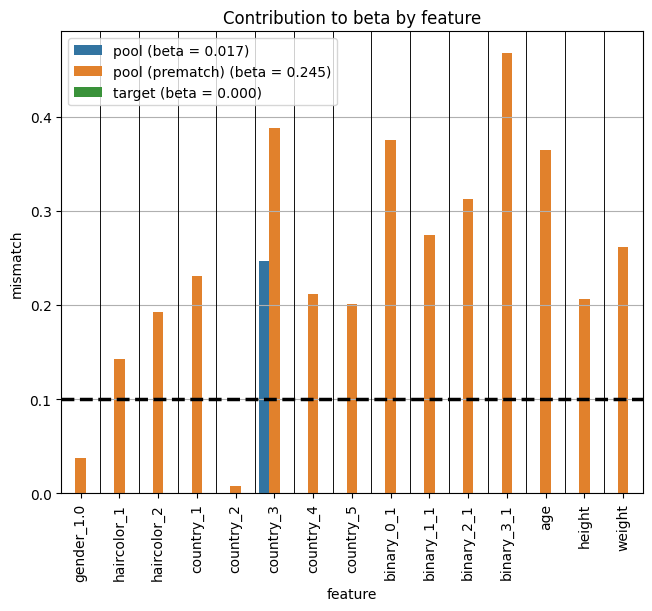

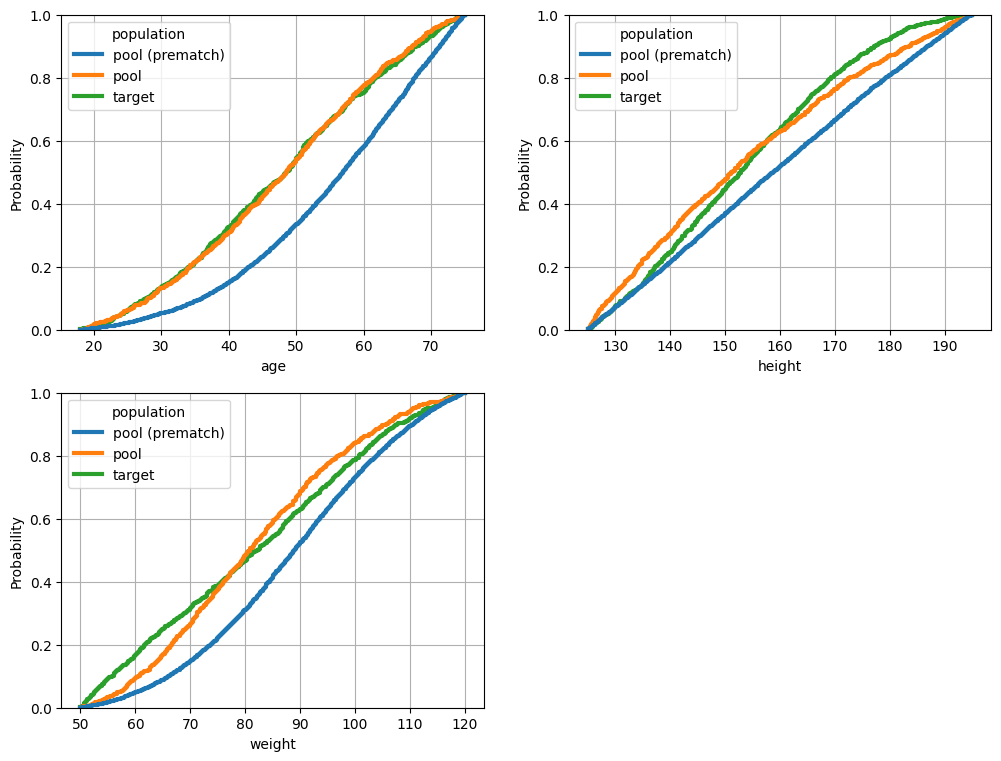

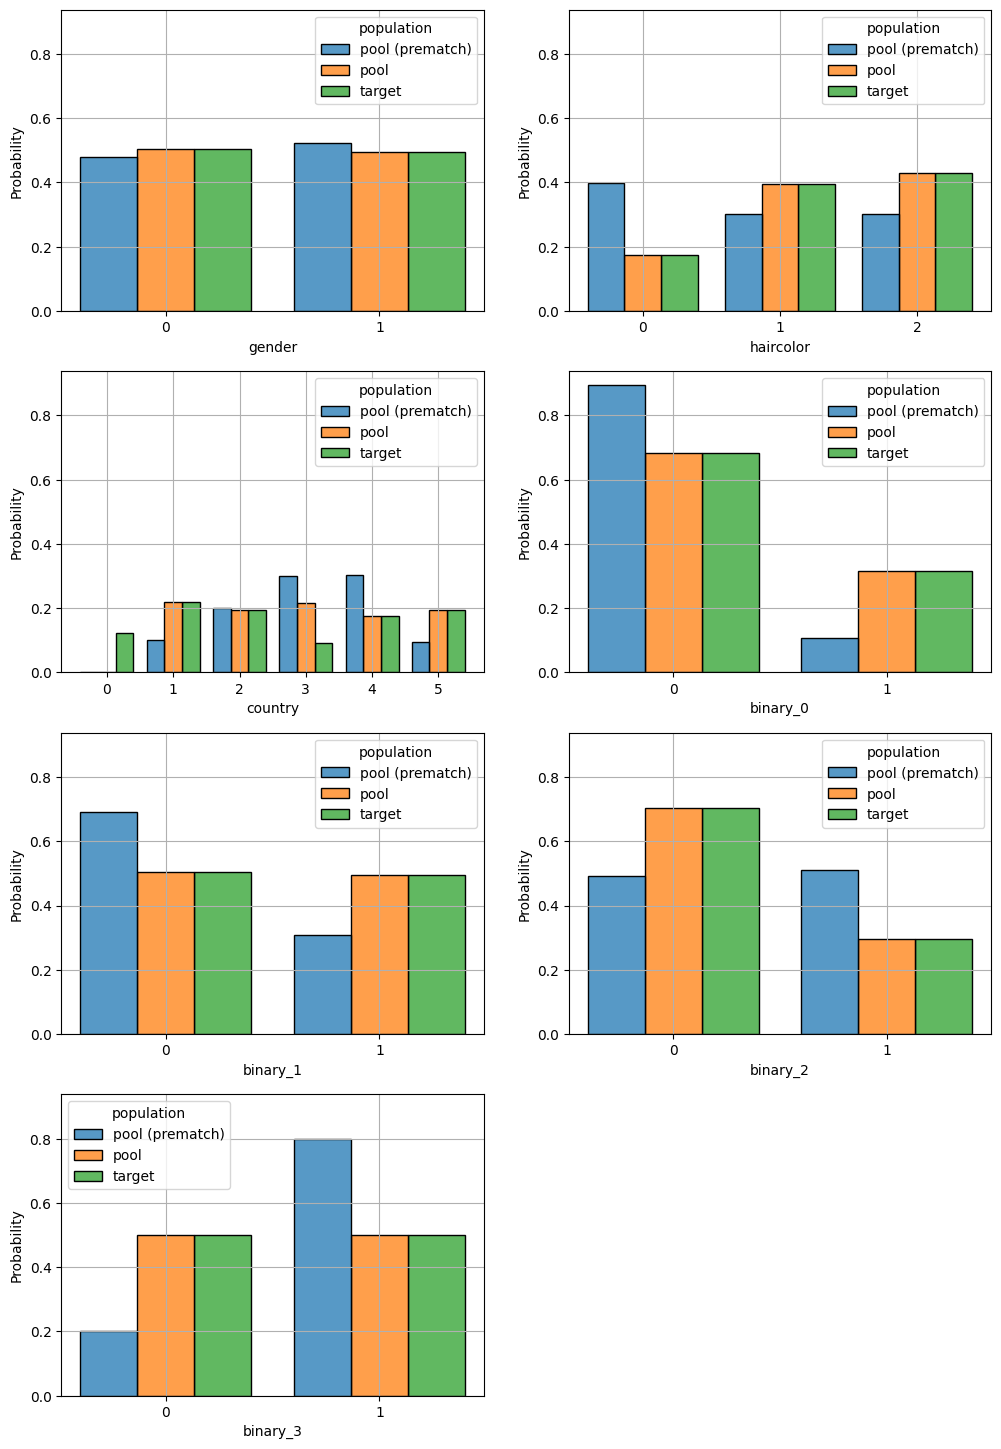

In [9]:
%matplotlib inline
match = matcher.get_best_match()
m_data = m.copy().get_population('pool')
m_data.loc[:, 'population'] = m_data['population'] + ' (prematch)'
match.append(m_data)
fig = plot_per_feature_loss(match, beta, 'target', debin=False)
fig = plot_numeric_features(match, hue_order=['pool (prematch)', 'pool', 'target', ])
fig = plot_categoric_features(match,  hue_order=['pool (prematch)', 'pool', 'target'])